# Example 3: Faults

### Generating data

In [3]:
# Importing and data
import theano.tensor as T
import theano
import sys, os
sys.path.append("../GeMpy")

# Importing GeMpy modules
import GeMpy

# Reloading (only for development purposes)
import importlib
importlib.reload(GeMpy)

# Usuful packages
import numpy as np
import pandas as pn

import matplotlib.pyplot as plt

# This was to choose the gpu
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Default options of printin
np.set_printoptions(precision = 6, linewidth= 130, suppress =  True)

#%matplotlib inline
%matplotlib inline



# Setting the extent
geo_data = GeMpy.import_data([0,10,0,10,0,10], [50,50,50])


# =========================
# DATA GENERATION IN PYTHON
# =========================
# Layers coordinates
layer_1 = np.array([[0.5,4,7], [2,4,6.5], [4,4,7], [5,4,6]])#-np.array([5,5,4]))/8+0.5
layer_2 = np.array([[3,4,5], [6,4,4],[8,4,4], [7,4,3], [1,4,6]])
layers = np.asarray([layer_1,layer_2])

# Foliations coordinates
dip_pos_1 = np.array([7,4,7])#- np.array([5,5,4]))/8+0.5
dip_pos_2 = np.array([2.,4,4])

# Dips
dip_angle_1 = float(15)
dip_angle_2 = float(340)
dips_angles = np.asarray([dip_angle_1, dip_angle_2], dtype="float64")

# Azimuths
azimuths = np.asarray([90,90], dtype="float64")

# Polarity
polarity = np.asarray([1,1], dtype="float64")

# Setting foliations and interfaces values
GeMpy.set_interfaces(geo_data, pn.DataFrame(
    data = {"X" :np.append(layer_1[:, 0],layer_2[:,0]),
            "Y" :np.append(layer_1[:, 1],layer_2[:,1]),
            "Z" :np.append(layer_1[:, 2],layer_2[:,2]),
            "formation" : np.append(
               np.tile("Layer 1", len(layer_1)), 
               np.tile("Layer 2", len(layer_2))),
            "labels" : [r'${\bf{x}}_{\alpha \, 0}^1$',
               r'${\bf{x}}_{\alpha \, 1}^1$',
               r'${\bf{x}}_{\alpha \, 2}^1$',
               r'${\bf{x}}_{\alpha \, 3}^1$',
               r'${\bf{x}}_{\alpha \, 0}^2$',
               r'${\bf{x}}_{\alpha \, 1}^2$',
               r'${\bf{x}}_{\alpha \, 2}^2$',
               r'${\bf{x}}_{\alpha \, 3}^2$',
               r'${\bf{x}}_{\alpha \, 4}^2$'] }))

GeMpy.set_foliations(geo_data,  pn.DataFrame(
    data = {"X" :np.append(dip_pos_1[0],dip_pos_2[0]),
            "Y" :np.append(dip_pos_1[ 1],dip_pos_2[1]),
            "Z" :np.append(dip_pos_1[ 2],dip_pos_2[2]),
            "azimuth" : azimuths,
            "dip" : dips_angles,
            "polarity" : polarity,
            "formation" : ["Layer 1", "Layer 2"],
            "labels" : [r'${\bf{x}}_{\beta \,{0}}$',
              r'${\bf{x}}_{\beta \,{1}}$'] })) 



layer_3 = np.array([[2,4,3], [4,4,4], [7,4,8]])
dip_pos_3 = np.array([1,4,1])
dip_angle_3 = float(140)
azimuth_3 = 90
polarity_3 = 1



GeMpy.set_interfaces(geo_data, pn.DataFrame(
    data = {"X" :layer_3[:, 0],
            "Y" :layer_3[:, 1],
            "Z" :layer_3[:, 2],
            "formation" : np.tile("Layer 3", len(layer_3)), 
            "labels" : [  r'${\bf{x}}_{\alpha \, 0}^3$',
                           r'${\bf{x}}_{\alpha \, 1}^3$',
                           r'${\bf{x}}_{\alpha \, 2}^3$'] }), append = True)
GeMpy.get_raw_data(geo_data,"interfaces")


GeMpy.set_foliations(geo_data, pn.DataFrame(data = {
                     "X" : dip_pos_3[0],
                     "Y" : dip_pos_3[1],
                     "Z" : dip_pos_3[2],
            
                     "azimuth" : azimuth_3,
                     "dip" : dip_angle_3,
                     "polarity" : polarity_3,
                     "formation" : [ 'Layer 3'],
                     "labels" : r'${\bf{x}}_{\beta \,{2}}$'}), append = True)

In [4]:
# When we choose the series we have to set the faults in the first place
GeMpy.set_data_series(geo_data, {'younger': ('Layer 1', 'Layer 2'),
                      'fault1': 'Layer 3'}, order_series = ['fault1', 'younger'])


In [5]:
# Select series to interpolate (if you do not want to interpolate all)
data_interp = GeMpy.set_interpolator(geo_data, u_grade = 0, verbose = [ 'faults_contribution',])

In [6]:
# This are the shared parameters and the compilation of the function. This will be hidden as well at some point
input_data_T = data_interp.interpolator.tg.input_parameters_list()

In [7]:
# HERE when we compile we have to pass the number of formations that are faults!!
debugging = theano.function(input_data_T, data_interp.interpolator.tg.whole_block_model(1), on_unused_input='ignore', 
                            allow_input_downcast=True, profile=True);

In [8]:
# This prepares the user data to the theano function
input_data_P = data_interp.interpolator.data_prep() 

In [9]:
# Solution of theano
sol = debugging(input_data_P[0], input_data_P[1], input_data_P[2], input_data_P[3],input_data_P[4], input_data_P[5])

Faults contribution __str__ = [ 0.  0.  0. ...,  0.  0.  0.]
Faults contribution __str__ = [ 0.023055  0.023055  0.023055 ...,  0.        0.        0.      ]


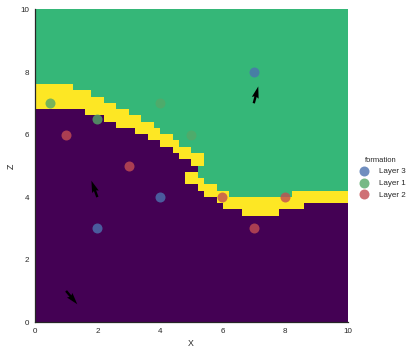

In [10]:
#GeMpy.plot_potential_field(fault1, sol.reshape(50,50,50),13, plot_data = True)
GeMpy.plot_section(geo_data, 30, block = sol, plot_data = True)

In [11]:
lith0 = sol == 0
lith1 = sol == 2
lith2 = sol == 3



In [13]:
import ipyvolume.pylab as p3
import ipyvolume.serialize
ipyvolume.serialize.performance = 1 # 1 for binary, 0 for JSON
#p3 = ipyvolume.pylab.figure(width=200,height=600)

In [15]:
p3.figure(width=800)

p3.scatter(geo_data.grid.grid[:,0][lith0],
           geo_data.grid.grid[:,1][lith0],
           geo_data.grid.grid[:,2][lith0], marker='box', color = 'blue' )

p3.scatter(geo_data.grid.grid[:,0][lith1],
           geo_data.grid.grid[:,1][lith1],
           geo_data.grid.grid[:,2][lith1], marker='box', color = 'yellow' )

p3.scatter(geo_data.grid.grid[:,0][lith2],
           geo_data.grid.grid[:,1][lith2],
           geo_data.grid.grid[:,2][lith2], marker='box', color = 'green' )
p3.show()